<a href="https://colab.research.google.com/github/nvinogradskaya/Geolife/blob/main/MyModel-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.6 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 614.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import uuid
import shutil
import matplotlib.pyplot as plt
import pickle
import h3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Concatenate, Dropout, LayerNormalization,
                                     LSTM, Add, MultiHeadAttention, GlobalAveragePooling1D, RepeatVector)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
from geopy.distance import distance

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MAX_USERS = 170
SEQ_LENGTH = 10
PRED_LENGTH = 1
EMBEDDING_DIM = 16
HIDDEN_DIM = 64
BATCH_SIZE = 128
EPOCHS = 20
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Data/"
SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/my-model-v10/"
SEQ_SAVE_PATH = os.path.join(SAVE_PATH, 'sequences/')
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)
features = ['lat', 'lon', 'alt', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

In [ ]:
def latlon_to_h3(lat, lon, resolution):
    return h3.latlng_to_cell(lat, lon, resolution)

def add_h3_indices(df):
    df['h3_500m'] = df.apply(lambda row: latlon_to_h3(row['lat'], row['lon'], 8), axis=1)
    df['h3_5m'] = df.apply(lambda row: latlon_to_h3(row['lat'], row['lon'], 14), axis=1)
    return df

In [ ]:
def load_and_preprocess_data(data_path, max_users=MAX_USERS):
    data = []
    user_dirs = sorted(os.listdir(data_path))[:max_users]

    for user in user_dirs:
        traj_dir = os.path.join(data_path, user, 'Trajectory')
        traj_files = sorted([f for f in os.listdir(traj_dir) if f.endswith('.plt')])

        for traj_file in traj_files:
            df = pd.read_csv(
                os.path.join(traj_dir, traj_file),
                skiprows=6, header=None, usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )
            df['user'] = user
            data.append(df)

    df = pd.concat(data, ignore_index=True)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.sort_values(by=['user', 'datetime'], inplace=True)
    df = df[(df['lat'] != 0) & (df['lon'] != 0)].ffill()
    df = add_h3_indices(df)

    def normalize_coords(row, resolution):
        cell_center = h3.cell_to_latlng(row[f'h3_{resolution}m'])
        local_lat = row['lat'] - cell_center[0]
        local_lon = row['lon'] - cell_center[1]
        return pd.Series([local_lat, local_lon])

    df[['local_lat_500m', 'local_lon_500m']] = df.apply(
        normalize_coords, args=('500',), axis=1
    )
    df[['local_lat_5m', 'local_lon_5m']] = df.apply(
        normalize_coords, args=('5',), axis=1
    )

    scaler = StandardScaler()
    df[['lat', 'lon', 'alt']] = scaler.fit_transform(df[['lat', 'lon', 'alt']])

    df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek / 7)

    le_500 = LabelEncoder()
    df['h3_500m_encoded'] = le_500.fit_transform(df['h3_500m'])
    user_ids = {user: idx for idx, user in enumerate(df['user'].unique())}
    df['user_id'] = df['user'].map(user_ids)

    return df, user_ids, scaler, le_500

In [ ]:
def create_sequences_and_save(df, user_ids, seq_length, pred_length=1, test_size=0.3, save_path='./seq_data'):
    os.makedirs(save_path, exist_ok=True)
    features = ['lat', 'lon', 'alt', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    targets = ['lat', 'lon']

    for user, user_df in df.groupby('user'):
        uid = user_ids[user]
        user_df = user_df.reset_index(drop=True)
        split_idx = int(len(user_df) * (1 - test_size))
        if split_idx <= seq_length:
            continue

        def save_chunk(X, y, h3, is_train):
            suffix = 'train' if is_train else 'test'
            chunk_id = uuid.uuid4().hex
            np.savez_compressed(
                os.path.join(save_path, f'user_{uid}_{suffix}_{chunk_id}.npz'),
                X=X, y=y, h3=h3, user_id=uid
            )

        def process_chunk(data, is_train=True):
            data_values = data[features].values
            target_values = data[targets].values

            # Генерация X: окна из seq_length шагов
            X = np.lib.stride_tricks.sliding_window_view(data_values, (seq_length, data_values.shape[1]))
            X = X.squeeze()  # (num_samples, seq_length, num_features)

            # Генерация y: следующий шаг ПОСЛЕ окна (pred_length=1)
            y_start = seq_length  # первый y идет после первого окна
            y = target_values[y_start : y_start + len(X)]

            # H3-метка берется для последнего шага в окне
            h3_labels = data['h3_500m_encoded'].values[seq_length-1 : seq_length-1 + len(X)]

            # Совмещение размерностей
            min_length = min(len(X), len(y), len(h3_labels))
            X = X[:min_length]
            y = y[:min_length]
            h3_labels = h3_labels[:min_length]

            # Сохранение чанков
            for i in range(0, len(X), 1000):
                save_chunk(X[i:i+1000], y[i:i+1000], h3_labels[i:i+1000], is_train)

        # Обработка train и test данных
        process_chunk(user_df.iloc[:split_idx], True)
        process_chunk(user_df.iloc[split_idx-seq_length:], False)

In [ ]:
def load_all_sequences_from_disk(save_path):
    X_train, X_test, y_train, y_test = [], [], [], []
    h3_train, h3_test = [], []
    users_train, users_test = [], []

    for fname in sorted(os.listdir(save_path)):
        if not fname.endswith('.npz'):
            continue

        data = np.load(os.path.join(save_path, fname))
        split_type = 'train' if 'train' in fname else 'test'
        uid = int(fname.split('_')[1])

        X, y = data['X'], data['y']
        h3 = data['h3']

        if split_type == 'train':
            X_train.append(X)
            y_train.append(y)
            h3_train.append(h3)
            users_train.append(np.full(len(X), uid))
        else:
            X_test.append(X)
            y_test.append(y)
            h3_test.append(h3)
            users_test.append(np.full(len(X), uid))

    return (
        np.concatenate(X_train), np.concatenate(X_test),
        np.concatenate(y_train), np.concatenate(y_test),
        np.concatenate(h3_train), np.concatenate(h3_test),
        np.concatenate(users_train), np.concatenate(users_test)
    )

In [ ]:
def contrastive_model(input_shape, embedding_dim):
    inp = Input(shape=input_shape)
    x = LSTM(32)(inp)
    x = Dense(embedding_dim)(x)
    return Model(inputs=inp, outputs=x)

def triplet_loss_fn(a, p, n, margin=1.0):
    ap_dist = tf.reduce_sum(tf.square(a - p), axis=1)
    an_dist = tf.reduce_sum(tf.square(a - n), axis=1)
    return tf.reduce_mean(tf.maximum(ap_dist - an_dist + margin, 0.0))

def create_triplets(X, user_ids):
    anchors, positives, negatives = [], [], []
    for uid in np.unique(user_ids):
        same_user_idx = np.where(user_ids == uid)[0]
        diff_user_idx = np.where(user_ids != uid)[0]
        if len(same_user_idx) < 2:
            continue
        for i in range(min(len(same_user_idx) - 1, 100)):
            a_idx, p_idx = same_user_idx[i], same_user_idx[i+1]
            n_idx = np.random.choice(diff_user_idx)
            anchors.append(X[a_idx])
            positives.append(X[p_idx])
            negatives.append(X[n_idx])
    return np.array(anchors), np.array(positives), np.array(negatives)


In [ ]:
# двухуровневая модель
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# макромодель (предсказывает следующую ячейку 500м)
def build_macro_model(input_shape, num_classes):
    seq_input = Input(shape=input_shape)
    x = LSTM(64)(seq_input)
    output = Dense(num_classes, activation='softmax', name='macro_output')(x)
    return Model(inputs=seq_input, outputs=output, name='macro_model')

def build_micro_model(input_shape, num_macro_features):
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

    attention = MultiHeadAttention(num_heads=2, key_dim=HIDDEN_DIM)
    context_vector = attention(encoder_outputs, encoder_outputs)

    context_last = GlobalAveragePooling1D()(context_vector)
    macro_features = Input(shape=(num_macro_features,))
    combined = Concatenate()([context_last, macro_features])

    output = Dense(2, activation='linear', name='micro_output')(combined)

    return Model(
        inputs=[encoder_inputs, macro_features],
        outputs=output,
        name='micro_model'
    )


class ArgMaxLayer(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(ArgMaxLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.argmax(inputs, axis=self.axis)

class H3CellToCoordLayer(tf.keras.layers.Layer):
    def __init__(self, cell_centers, **kwargs):
        super().__init__(**kwargs)
        self.cell_centers = np.array(cell_centers, dtype=np.float32)

    def call(self, inputs):
        indices = tf.cast(inputs, tf.int32)
        return tf.gather(self.cell_centers, indices)

    def get_config(self):
        config = super().get_config()
        config.update({"cell_centers": self.cell_centers.tolist()})
        return config

def build_dual_scale_model(macro_input_shape, micro_input_shape, num_macro_classes, embedding_dim, le_500):

    macro_input = Input(shape=macro_input_shape, name='macro_input')
    micro_input = Input(shape=micro_input_shape, name='micro_input')
    user_input = Input(shape=(embedding_dim,), name='user_input')

    macro_model = build_macro_model(macro_input_shape, num_macro_classes)
    macro_output_raw = macro_model(macro_input)
    macro_output = tf.keras.layers.Lambda(lambda x: x, name='macro_output')(macro_output_raw)

    cell_ids = le_500.classes_
    cell_centers = [h3.cell_to_latlng(cell) for cell in cell_ids]
    cell_centers_layer = H3CellToCoordLayer(cell_centers)

    macro_output_idx = ArgMaxLayer(axis=-1, name='macro_output_idx')(macro_output_raw)
    cell_centers = cell_centers_layer(macro_output_idx)

    combined_features = Concatenate()([cell_centers, user_input])
    micro_model = build_micro_model(micro_input_shape, num_macro_features=combined_features.shape[-1])
    micro_output_raw = micro_model([micro_input, combined_features])
    micro_output = tf.keras.layers.Lambda(lambda x: x, name='micro_output')(micro_output_raw)

    return Model(
        inputs=[macro_input, micro_input, user_input],
        outputs=[macro_output, micro_output],
        name='DualScaleModel'
    )


In [ ]:
class CombinedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_macro, X_micro, user_embeddings, y, h3_labels, batch_size=128):
        self.X_macro = X_macro
        self.X_micro = X_micro
        self.user_embeddings = user_embeddings
        self.y = y
        self.h3_labels = h3_labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X_macro) / self.batch_size))

    def __getitem__(self, index):
        batch_X_macro = self.X_macro[index*self.batch_size : (index+1)*self.batch_size]
        batch_X_micro = self.X_micro[index*self.batch_size : (index+1)*self.batch_size]
        batch_user = self.user_embeddings[index*self.batch_size : (index+1)*self.batch_size]
        batch_y = self.y[index*self.batch_size : (index+1)*self.batch_size]
        batch_h3 = self.h3_labels[index*self.batch_size : (index+1)*self.batch_size]

        return (
            {
                'macro_input': batch_X_macro,
                'micro_input': batch_X_micro,
                'user_input': batch_user
            },
            {
                'macro_output': batch_h3,
                'micro_output': batch_y  # Размерность (batch_size, 2)
            }
        )

In [ ]:
print("\nЗагрузка данных")
start_load = time.time()
df, user_ids, scaler, le_500 = load_and_preprocess_data(DATA_PATH)
load_time = time.time() - start_load
print(f"Время загрузки данных: {load_time:.2f} сек")


Загрузка данных
Время загрузки данных: 7253.65 сек


In [ ]:
shutil.rmtree(SEQ_SAVE_PATH, ignore_errors=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)
create_sequences_and_save(df, user_ids, SEQ_LENGTH, save_path=SEQ_SAVE_PATH)

In [ ]:
X_train, X_test, y_train, y_test, h3_train, h3_test, users_train, users_test = load_all_sequences_from_disk(SEQ_SAVE_PATH)
print("размерности/")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

размерности/
X_train: (17235769, 10, 7)
y_train: (17235769, 2)


In [ ]:
print(f"h3_train shape: {h3_train.shape}")

h3_train shape: (17235769,)


In [ ]:
print(f"X_train: {X_train.shape}, h3_train: {h3_train.shape}")

X_train: (17235939, 10, 7), h3_train: (17235939,)


In [ ]:
anchors, positives, negatives = create_triplets(X_train, users_train)
triplet_encoder = contrastive_model(X_train.shape[1:], EMBEDDING_DIM)
optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
early_stopping = EarlyStopping(
    monitor="loss",
    patience=2,
    restore_best_weights=True,
    mode="min"
)

best_weights = None
best_loss = float('inf')
wait = 0

for epoch in range(20):
    with tf.GradientTape() as tape:
        emb_a = triplet_encoder(anchors)
        emb_p = triplet_encoder(positives)
        emb_n = triplet_encoder(negatives)
        loss = triplet_loss_fn(emb_a, emb_p, emb_n)
    grads = tape.gradient(loss, triplet_encoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, triplet_encoder.trainable_variables))

    print(f"contrastive epoch {epoch+1} // loss = {loss.numpy():.4f}")

    if loss < best_loss:
        best_loss = loss
        best_weights = triplet_encoder.get_weights()
        wait = 0
    else:
        wait += 1
        if wait >= early_stopping.patience:
            print(f"Ранняя остановка на эпохе {epoch+1}")
            triplet_encoder.set_weights(best_weights)
            break

if epoch + 1 < 10:
    print(f"Восстановлены лучшие веса с loss = {best_loss:.4f}")

contrastive epoch 1 // loss = 0.1440
contrastive epoch 2 // loss = 0.1307
contrastive epoch 3 // loss = 0.1190
contrastive epoch 4 // loss = 0.1088
contrastive epoch 5 // loss = 0.1002
contrastive epoch 6 // loss = 0.0930
contrastive epoch 7 // loss = 0.0865
contrastive epoch 8 // loss = 0.0805
contrastive epoch 9 // loss = 0.0750
contrastive epoch 10 // loss = 0.0700
contrastive epoch 11 // loss = 0.0653
contrastive epoch 12 // loss = 0.0608
contrastive epoch 13 // loss = 0.0566
contrastive epoch 14 // loss = 0.0528
contrastive epoch 15 // loss = 0.0491
contrastive epoch 16 // loss = 0.0458
contrastive epoch 17 // loss = 0.0426
contrastive epoch 18 // loss = 0.0396
contrastive epoch 19 // loss = 0.0370
contrastive epoch 20 // loss = 0.0348


In [ ]:
user_embeddings_matrix = {}
for uid in np.unique(users_train):
    user_seqs = X_train[users_train == uid]
    user_embs = triplet_encoder.predict(user_seqs, batch_size=1024)
    user_embeddings_matrix[uid] = np.mean(user_embs, axis=0)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
196/196 ━━━━━━━━━━━━━

In [ ]:
user_embeddings_train = np.array([user_embeddings_matrix[uid] for uid in users_train])
user_embeddings_test = np.array([user_embeddings_matrix[uid] for uid in users_test])

In [ ]:
def create_tf_dataset(generator):
    output_signature = (
        {
            'macro_input': tf.TensorSpec(shape=(None, SEQ_LENGTH, len(features)), dtype=tf.float32),
            'micro_input': tf.TensorSpec(shape=(None, SEQ_LENGTH, len(features)), dtype=tf.float32),
            'user_input': tf.TensorSpec(shape=(None, EMBEDDING_DIM), dtype=tf.float32)
        },
        {
            'macro_output': tf.TensorSpec(shape=(None,), dtype=tf.int32),
            'micro_output': tf.TensorSpec(shape=(None, PRED_LENGTH, 2), dtype=tf.float32)
        }
    )
    return tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )

In [ ]:
model = build_dual_scale_model(
    macro_input_shape=(SEQ_LENGTH, len(features)),
    micro_input_shape=(SEQ_LENGTH, len(features)),
    num_macro_classes=len(le_500.classes_),
    embedding_dim=EMBEDDING_DIM,
    le_500=le_500
)

model.compile(
    optimizer='adam',
    loss={
        'macro_output': 'sparse_categorical_crossentropy',
        'micro_output': 'mse'
    },
    loss_weights={'macro_output': 0.3, 'micro_output': 0.7},
    metrics={'micro_output': ['mae']}
)

In [ ]:
print(model.output_names)

ListWrapper(['macro_output', 'micro_output'])


In [ ]:
train_gen = CombinedDataGenerator(X_train, X_train, user_embeddings_train, y_train, h3_train, BATCH_SIZE)
val_gen = CombinedDataGenerator(X_test, X_test, user_embeddings_test, y_test, h3_test, BATCH_SIZE)

In [ ]:
train_dataset = create_tf_dataset(train_gen)
val_dataset = create_tf_dataset(val_gen)

In [ ]:
SAVE_PATH2 = "/content/drive/My Drive/Colab Notebooks/my-model-v10/model.keras"
print("\nОбучение модели ===")
start_train = time.time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(SAVE_PATH2, save_best_only=True)
    ]
)
train_time = time.time() - start_train
print(f"Время обучения: {train_time:.2f} сек")


Обучение модели ===
Epoch 1/15
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 11912s 88ms/step - loss: 2.1944 - macro_output_loss: 7.0818 - micro_output_loss: 0.0997 - micro_output_mae: 0.1056 - val_loss: 1.9987 - val_macro_output_loss: 6.5694 - val_micro_output_loss: 0.0398 - val_micro_output_mae: 0.0966
Epoch 2/15
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 11939s 89ms/step - loss: 1.7081 - macro_output_loss: 5.6642 - micro_output_loss: 0.0127 - micro_output_mae: 0.0483 - val_loss: 1.9131 - val_macro_output_loss: 6.3672 - val_micro_output_loss: 0.0043 - val_micro_output_mae: 0.0286
Epoch 3/15
134655/134655 ━━━━━━━━━━━━━━━━━━━━ 11830s 88ms/step - loss: 1.5829 - macro_output_loss: 5.2552 - micro_output_loss: 0.0090 - micro_output_mae: 0.0419 - val_loss: 1.8814 - val_macro_output_loss: 6.2483 - val_micro_output_loss: 0.0099 - val_micro_output_mae: 0.0226
Epoch 4/15
  4683/134655 ━━━━━━━━━━━━━━━━━━━━ 2:27:20 68ms/step - loss: 1.3948 - macro_output_loss: 4.6329 - micro_output_loss: 0.0070 - micro_output_mae:

In [ ]:
from sklearn.metrics import mean_absolute_error

def inverse_transform_coords(coords, scaler):
    n = coords.shape[-1]
    dummy = np.zeros((coords.shape[0] * coords.shape[1], scaler.mean_.shape[0]))
    dummy[:, :n] = coords.reshape(-1, n)
    rescaled = scaler.inverse_transform(dummy)[:, :n]
    return rescaled.reshape(coords.shape)

def evaluate_micro_output(y_true, y_pred, scaler):
    y_true_orig = inverse_transform_coords(y_true, scaler)
    y_pred_orig = inverse_transform_coords(y_pred, scaler)

    mae_lat = mean_absolute_error(y_true_orig[..., 0].flatten(), y_pred_orig[..., 0].flatten())
    mae_lon = mean_absolute_error(y_true_orig[..., 1].flatten(), y_pred_orig[..., 1].flatten())

    print(f"MAE Latitude: {mae_lat:.4f}")
    print(f"MAE Longitude: {mae_lon:.4f}")
    print(f"Total MAE (avg): {(mae_lat + mae_lon) / 2:.4f}")
from sklearn.metrics import accuracy_score

def evaluate_macro_output(y_true, y_pred_logits):
    y_pred = np.argmax(y_pred_logits, axis=-1)
    acc = accuracy_score(y_true, y_pred)
    print(f"Macro Accuracy (H3): {acc * 100:.2f}%")

def evaluate_model(model, X_macro, X_micro, user_embeddings, y_micro, y_macro, scaler, batch_size=128):
    preds = model.predict(
        {'macro_input': X_macro, 'micro_input': X_micro, 'user_input': user_embeddings},
        batch_size=batch_size
    )
    y_macro_pred, y_micro_pred = preds

    print("🔍 Evaluating Macro Output:")
    evaluate_macro_output(y_macro, y_macro_pred)

    print("\n🔍 Evaluating Micro Output:")
    evaluate_micro_output(y_micro, y_micro_pred, scaler)


In [ ]:
evaluate_model(
    model,
    X_test, X_test,
    user_embeddings_test,
    y_test, h3_test,
    scaler
)


1244/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step
🔍 Evaluating Macro Output:
Macro Accuracy (H3): 29.04%

🔍 Evaluating Micro Output:
MAE Latitude: 0.0541
MAE Longitude: 0.0508
Total MAE (avg): 0.0524


In [ ]:
### 1. Функция для расчета метрик ###
def evaluate_model_with_metrics(model, X_macro, X_micro, user_embeddings, y_micro, y_macro, scaler, h3_true, batch_size=128):
    # Измеряем время инференса
    start_time = time.time()

    # Делаем предсказания
    preds = model.predict(
        {'macro_input': X_macro, 'micro_input': X_micro, 'user_input': user_embeddings},
        batch_size=batch_size,
        verbose=0
    )
    inference_time = time.time() - start_time

    y_macro_pred, y_micro_pred = preds

    # Восстанавливаем исходные координаты
    y_true_orig = inverse_transform_coords(y_micro, scaler)
    y_pred_orig = inverse_transform_coords(y_micro_pred, scaler)

    # Рассчитываем все метрики
    errors = []
    lat_errors = []
    lon_errors = []
    max_error = 0

    # Для ADE/FDE
    ade_list = []
    fde_list = []

    for i in tqdm(range(len(y_true_orig)), desc="Calculating metrics"):
        # Для каждой точки в последовательности
        point_errors = []
        for t in range(y_true_orig.shape[1]):
            true_point = (y_true_orig[i,t,0], y_true_orig[i,t,1])
            pred_point = (y_pred_orig[i,t,0], y_pred_orig[i,t,1])

            # Расстояние в метрах
            dist = distance(true_point, pred_point).meters
            point_errors.append(dist)

            # Обновление максимальной ошибки
            if dist > max_error:
                max_error = dist

        # Для ADE/FDE
        ade_list.append(np.mean(point_errors))
        fde_list.append(point_errors[-1])

        # Для общих метрик
        errors.extend(point_errors)
        lat_errors.extend(np.abs(y_true_orig[i,:,0] - y_pred_orig[i,:,0]))
        lon_errors.extend(np.abs(y_true_orig[i,:,1] - y_pred_orig[i,:,1]))

    # Рассчет метрик
    metrics = {
        'MAE (м)': np.mean(errors),
        'RMSE (м)': np.sqrt(np.mean(np.array(errors)**2)),
        'ADE (м)': np.mean(ade_list),
        'FDE (м)': np.mean(fde_list),
        'Max Error (м)': max_error,
        'Lat MAE (deg)': np.mean(lat_errors),
        'Lon MAE (deg)': np.mean(lon_errors),
        'Macro Accuracy (H3)': accuracy_score(h3_true, np.argmax(y_macro_pred, axis=1)),
        'Inference Time': f"{inference_time:.2f} сек ({len(y_micro)/inference_time:.1f} samples/sec)"
    }

    return metrics

In [ ]:
print("\nОценка модели")
metrics = evaluate_model_with_metrics(
    model,
    X_test,
    X_test,
    user_embeddings_test,
    y_test,
    h3_test,
    scaler,
    h3_test
)

print("\nРезультаты")
for k, v in metrics.items():
    if 'Time' in k:
        print(f"{k}: {v}")
    elif 'Accuracy' in k:
        print(f"{k}: {v*100:.2f}%")
    elif 'deg' in k:
        print(f"{k}: {v:.6f}°")
    else:
        print(f"{k}: {v:.2f} м")

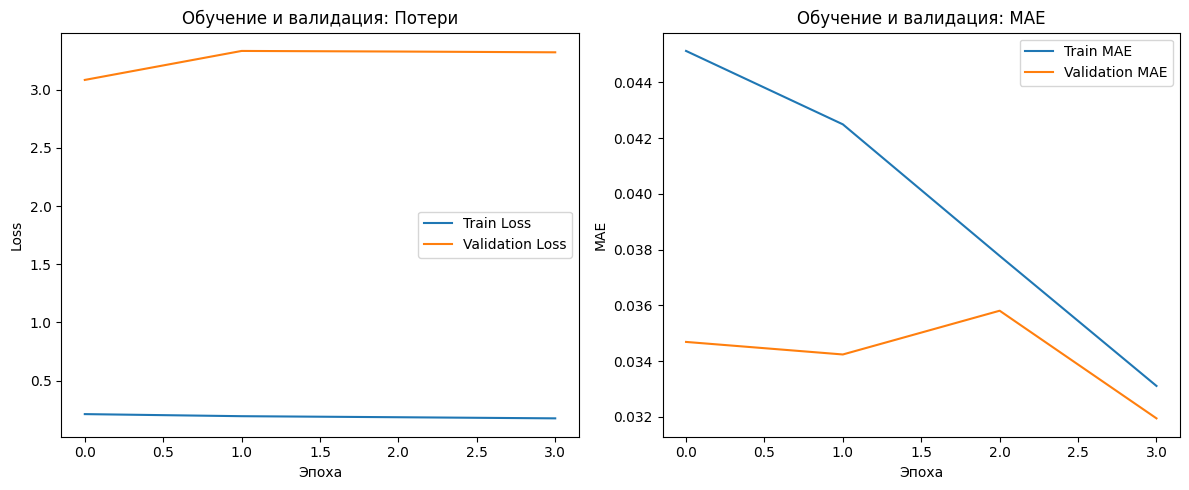

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Обучение и валидация: Потери')
    plt.ylabel('Loss')
    plt.xlabel('Эпоха')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['micro_output_mae'], label='Train MAE')
    plt.plot(history.history['val_micro_output_mae'], label='Validation MAE')
    plt.title('Обучение и валидация: MAE')
    plt.ylabel('MAE')
    plt.xlabel('Эпоха')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)